In [3]:
from transformer_lens import HookedTransformer
from datasets import load_dataset
import importlib
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import json

import patchscope

importlib.reload(patchscope)
from patchscope import next_token_patchscope

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [ ]:
model_name = "gpt-j-6B"
device = "cuda"
model = HookedTransformer.from_pretrained(model_name, device=device)

`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transforme

Loaded pretrained model gpt-j-6B into HookedTransformer


In [3]:
dataset = load_dataset(
    "EleutherAI/the_pile_deduplicated", split="train", streaming=True
)

Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

In [ ]:
torch.manual_seed(42)
random.seed(42)

methods = ["logitlens", "patchscope", "logitscope"]
n_take = 2000
prompts = [data["text"] for data in dataset.take(n_take)]
# This filters out ~50% of the prompts.
prompts = [
    prompt for prompt in prompts if len(prompt.split(" ")) < 200 and len(prompt) < 1600
]

for method in methods:
    results = []

    with tqdm(total=model.cfg.n_layers * len(prompts), desc=method) as pbar:
        for layer_src in range(model.cfg.n_layers):
            prec1s, surprisals = [], []

            for prompt_src in prompts:
                prompt_len = len(model.to_str_tokens(prompt_src))
                pos_src = random.randint(0, prompt_len - 1)

                if method == "logitlens":
                    prompt_tgt = prompt_src
                    layer_tgt = model.cfg.n_layers - 1
                    pos_tgt = pos_src
                    pos_pred = pos_tgt
                elif method == "patchscope":
                    prompt_tgt = "cat -> cat\n1135 -> 1135\nhello -> hello\n?"
                    layer_tgt = layer_src
                    pos_tgt = -1
                    pos_pred = -1
                    assert model.to_str_tokens(prompt_tgt)[pos_tgt] == "?"
                elif method == "logitscope":
                    prompt_tgt = "?"
                    layer_tgt = layer_src
                    pos_tgt = -1
                    pos_pred = pos_tgt
                    assert model.to_str_tokens(prompt_tgt)[pos_tgt] == "?"
                else:
                    raise ValueError(f"Unsupported method {method}")

                prec1, surprisal, _ = next_token_patchscope(
                    model=model,
                    prompt_src=prompt_src,
                    prompt_tgt=prompt_tgt,
                    layer_src=layer_src,
                    layer_tgt=layer_tgt,
                    pos_src=pos_src,
                    pos_tgt=pos_tgt,
                    pos_pred=pos_pred,
                )
                pbar.update(1)
                prec1s.append(prec1)
                surprisals.append(surprisal)

            results.append(
                {
                    "prec1": torch.tensor(prec1s).mean().item(),
                    "surprisal": torch.tensor(surprisals).mean().item(),
                }
            )

    with open(f"patchscope_{method}.json", "w") as f:
        json.dump(results, f, indent=4)

logitscope: 100%|██████████| 19544/19544 [39:26<00:00,  8.26it/s]


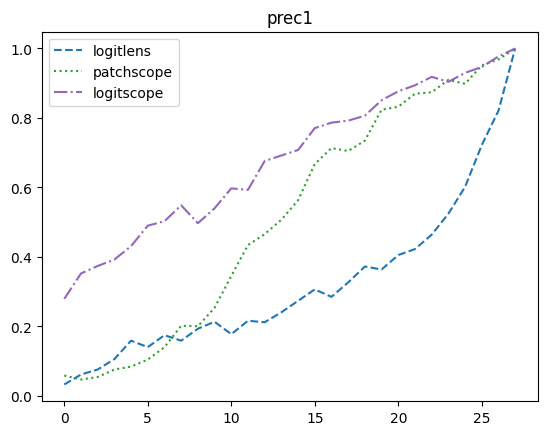

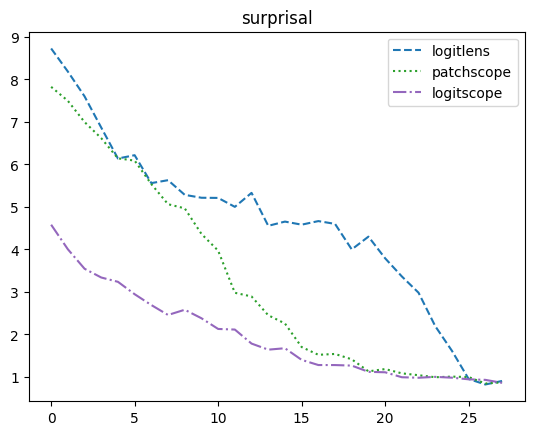

In [5]:
results = dict()

for method in methods:
    with open(f"patchscope_{method}.json") as f:
        results[method] = json.load(f)

for metric in ["prec1", "surprisal"]:
    # Use kwargs to match the styles in https://arxiv.org/pdf/2401.06102.
    plot_kwargs = {
        "logitlens": {"color": "#1f77b4", "ls": "dashed"},
        "patchscope": {"color": "#2ca02c", "ls": "dotted"},
        "logitscope": {"color": "#9467bd", "ls": "dashdot"},
    }
    for method in methods:
        plt.plot(
            [x[metric] for x in results[method]], label=method, **plot_kwargs[method]
        )
    plt.legend()
    plt.title(metric)
    plt.show()